In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import seaborn as sns

from netam import framework, models, experiment
from netam.common import parameter_count_of_model

In [2]:
data_path = "/Users/matsen/data/greiff-systems-oof_pcp_2023-11-30_MASKED.csv"
df = pd.read_csv(data_path, index_col=0)

df = df[df["parent"] != df["child"]]
# df = df.sample(3000)

In [3]:
train_sample_ids = ['hepb-vax_m4_plasma', 'no-vax_m2_plasma', 'np-hel-vax_m2_plasma', 'ova-vax_m4_plasma', 'np-hel-vax_m3_plasma', 'no-vax_m1_plasma', 'ova-vax_m2_plasma', 'hepb-vax_m3_plasma', 'ova-vax_m5_plasma', 'hepb-vax_m1_plasma', 'no-vax_m3_plasma', 'no-vax_m4_plasma', 'ova-vax_m3_plasma', 'np-hel-vax_m1_plasma', 'np-hel-vax_m5_plasma']
val_sample_ids = ['no-vax_m5_plasma', 'ova-vax_m1_plasma', 'hepb-vax_m2_plasma', 'np-hel-vax_m4_plasma']

train_df = df[df["sample_id"].isin(train_sample_ids)]
val_df = df[df["sample_id"].isin(val_sample_ids)]

assert len(train_df) + len(val_df) == len(df)

In [4]:
expt = experiment.Experiment()

train_data_by_kmer_length = expt.data_by_kmer_length_of(train_df)
val_data_by_kmer_length = expt.data_by_kmer_length_of(val_df)

Using Metal Performance Shaders


In [5]:
training_params_by_model_name = {
    "mm_cnn_lrg": {"l2_regularization_coeff": 5e-7},
}

expt_df = expt.build_experiment_df("mm", train_data_by_kmer_length, val_data_by_kmer_length, training_params_by_model_name)

def view(expt_df):
    return expt_df.drop(columns=["model", "train_dataset", "val_dataset"])
    
view(expt_df)

,model_name,parameter_count,kmer_length,training_params
0,mm_cnn_sml,1007,3,{}
1,mm_cnn_med_orig,1495,3,{}
2,mm_cnn_med,1496,3,{}
3,mm_cnn_lrg,1957,3,{'l2_regularization_coeff': 5e-07}
4,mm_cnn_4k,3665,3,{}
5,mm_cnn_4k_k13,3941,3,{}
6,mm_cnn_8k,6211,3,{}
7,mm_cnn_8k_drp01,6211,3,{}
8,mm_cnn_8k_drp02,6211,3,{}
9,mm_cnn_8k_drp03,6211,3,{}


In [6]:
expt.train_experiment_df(expt_df)

	Loading pre-trained mm_cnn_sml...
	Loading pre-trained mm_cnn_med_orig...
	Loading pre-trained mm_cnn_med...
	Loading pre-trained mm_cnn_lrg...
	Loading pre-trained mm_cnn_4k...
	Loading pre-trained mm_cnn_4k_k13...
	Loading pre-trained mm_cnn_8k...
	Loading pre-trained mm_cnn_8k_drp01...
	Loading pre-trained mm_cnn_8k_drp02...
	Loading pre-trained mm_cnn_8k_drp03...
	Loading pre-trained mm_fivemer...
	Loading pre-trained mm_shmoof...


In [7]:
expt_df["val_loss"] = expt.loss_of_dataset_dict(expt_df, val_data_by_kmer_length)

view(expt_df)

,model_name,parameter_count,kmer_length,training_params,val_loss
0,mm_cnn_sml,1007,3,{},0.035199
1,mm_cnn_med_orig,1495,3,{},0.035080
2,mm_cnn_med,1496,3,{},0.035123
3,mm_cnn_lrg,1957,3,{'l2_regularization_coeff': 5e-07},0.035044
4,mm_cnn_4k,3665,3,{},0.034786
5,mm_cnn_4k_k13,3941,3,{},0.034848
6,mm_cnn_8k,6211,3,{},0.034703
7,mm_cnn_8k_drp01,6211,3,{},0.034738
8,mm_cnn_8k_drp02,6211,3,{},0.034760
9,mm_cnn_8k_drp03,6211,3,{},0.034970


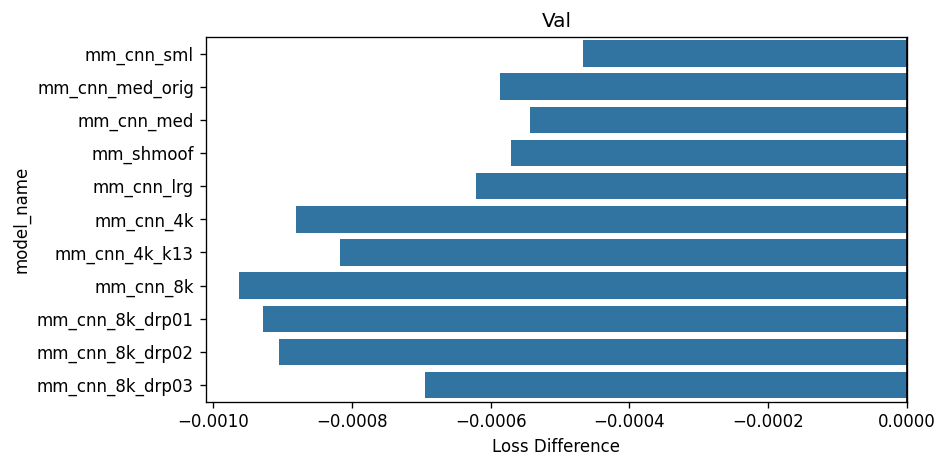

In [8]:
experiment.plot_loss_difference(expt_df, baseline_model_name='mm_fivemer')
